# Incremental decomposition scheme for mechanosoprtive strain calculation
#### *A. Ferrara and F.K. Wittel "Mechanosorptive Creep of Norway Spruce on the Tissue Scale Perpendicular to Grain"*, *Holzforschung* (2025)

This Notebook allows to plot the data contained in **_MS_Creep_Tests_Dataset_** ([10.17632/rsrsw8h7mv.1]()). The dataset contains experimental results from our study (Ferrara and Wittel, 2025b), in which **mechanosorptive creep** tests were performed on **Norway spruce tissue slices** in the transverse anatomical directions, radial (R) and tangential (T), under cyclic relative humidity (RH) between 30% and 90%. Samples were cut in the orientations **{RL, RT, TR}**, where the first letter denotes the longitudinal dimension and the second the transverse width, all comprising alternating bands of earlywood (EW) and latewood (LW). Tests were carried out at **different loading degrees (LD)**: {RL, RT} at 30% and 50%, and {TR} at 40% of the respective tensile strength. Reference tensile strengths were taken from our earlier work (Ferrara and Wittel, 2024).

The dataset is organized by sample type, with each file containing multiple sheets corresponding to individual experiments. Each sheet reports detailed information about the sample (e.g., dimensions, loading degree, etc.), together with time, moisture content, and mechanosorptive creep strain and compliance. The mechanosorptive creep strain was calculated by applying the proposed incremental decomposition scheme to isolate them from the total strain directly measured with Digital Image Correlation (DIC).

In addition, The dataset includes two CSV files with the results of:  
- **Tensile elastic tests** on Norway spruce tissue slices, provided as mean elastic compliance values from our earlier work (Ferrara and Wittel, 2024), enabling analyses of how creep compliance scales with elastic compliance  
- **Tensile creep tests**, provided as element compliances of the Kelvin–Voigt model describing the mean viscoelastic compliances from our previous work (Ferrara and Wittel, 2025a), which serve as input for calculating the viscoelastic strain component  
and one NPZ file with the results of
- **Dynamic Vapor Sorption (DVS) tests** on a RL-slice, following the RH profile applied in the mechanosorptive experiments.

### Imports and working path
Run the following section to import the required libraries and download the data folder in the current directory.

In [1]:
import os
import ast
import requests
import zipfile
from math import *
import numpy as np
import pandas as pd
import glob
from collections import defaultdict
from scipy.optimize import lsq_linear
from scipy.optimize import least_squares
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import matplotlib.cm as cm

# Download dataset in the current folder
url = "https://data.mendeley.com/public-files/datasets/rsrsw8h7mv/files/c74b8815-a92e-4921-975b-47f9dcebeb3d/file_downloaded" # Link to dataset folder
extraction_path = os.getcwd()  # path to current folder
zip_file_path = os.path.join(extraction_path, "downloaded_folder.zip")  # path to folder where the zip file will be saved
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"} # get headers (optional, but recommended for some sites)
response = requests.get(url, headers=headers) # get response from URL
if response.status_code == 200:
    with open(zip_file_path, "wb") as f:  # download the zip file
        f.write(response.content)   
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:  # unzip the file
            zip_ref.extractall(extraction_path)
        extracted_file = zip_ref.namelist()[0]  # name of the extracted folder
        folder_path = os.path.join(extraction_path, extracted_file) # path to dataset folder
        print(f"Working in: {folder_path}")
        os.remove(zip_file_path)  # remove the downloaded zip file
    except zipfile.BadZipFile:
        print("Error: The file is not a zip file or it is corrupted.")
else:
    print(f"Failed to download. Status code: {response.status_code}")

# Set file paths
dvs_path = folder_path + 'dvs_data.npz'
elastic_path = folder_path + 'elastic_compliances_Ferrara_Wittel_2024.csv'
viscoel_path = folder_path + 'master_vec_prony_param.csv'

Working in: C:\Users\Falk\Documents\MS_Creep_Tests_Dataset/


### Customized functions
Run the following section to make the custom functions available for use in the rest of the notebook.

In [2]:
# Retrieve experiment datasets
def read_sheet_meta_and_data(xlsx_path, sheet_name):
    df_all = pd.read_excel(xlsx_path, sheet_name=sheet_name, header=None)
    # Find header row
    header_row = None
    for i in range(len(df_all)):
        v = str(df_all.iloc[i, 0]) if pd.notna(df_all.iloc[i, 0]) else ""
        if v.strip() == "Time [h]":
            header_row = i
            break
    if header_row is None:
        raise ValueError(f'Could not find "Time [h]" header in {os.path.basename(xlsx_path)}:{sheet_name}')

    # Meta above header (skip the blank row just before header)
    meta_pairs = df_all.iloc[:header_row-1, :2].dropna(how='all')
    meta = {}
    for _, r in meta_pairs.iterrows():
        k = r.iloc[0]
        v = r.iloc[1]
        if pd.isna(k):
            continue
        k = str(k)
        if k not in meta and not (isinstance(v, float) and np.isnan(v)):
            meta[k] = v

    # Data table from header_row
    data_tbl = pd.read_excel(xlsx_path, sheet_name=sheet_name, header=header_row)
    return meta, data_tbl
# end: def read_sheet_meta_and_data

# Extract KV-compliances from excel
def extract_comp(meta):
    c1 = float(meta.get('Compliance_1 [1/GPa]', np.nan))/1000
    c2 = float(meta.get('Compliance_2 [1/GPa]', np.nan))/1000
    c3 = float(meta.get('Compliance_3 [1/GPa]', np.nan))/1000
    return np.array([c1, c2, c3], dtype=float)
# end: def extract_comp

# Extract loading degree from excel
def ld_from_meta(meta):
    val = meta.get('Loading Degree [%]', meta.get('Nominal Loading Degree [-]', np.nan))
    try:
        v = float(val)
        return v/100.0 if v > 1.5 else v
    except Exception:
        return np.nan
# end: def ld_from_meta

# Generate stress array
def stress_series(meta, data_tbl, t):
    if 'Stress [MPa]' in data_tbl.columns:
        s = data_tbl['Stress [MPa]'].to_numpy(dtype=float)
        if len(s) == len(t):
            return s
    s0 = float(meta.get('Creep Stress [MPa]', np.nan))
    return np.full(len(t), s0, dtype=float)
# end: def stress_series

# Group colors 
def group_and_colors(entries):
    colors_by_ld, _ = build_ld_colormaps(entries, cmap_dict)
    grouped = defaultdict(list)
    for e in entries:
        grouped[e['ld']].append(e)
    return grouped, colors_by_ld
# end: def group_and_colors

# Build moisture cycles with different first sorption with corresponding time and stress
def build_cycles_with_initial(tdata0, wdata0, tdata, wdata, total_cycles, stress_value, stressed_cycles):
    
    # Convert to arrays
    t0 = np.asarray(tdata0)
    w0 = np.asarray(wdata0)
    t  = np.asarray(tdata)
    w  = np.asarray(wdata)

    # Determine cycle period
    dt = t[-1] - t[-2]
    period = (t[-1] - t[0]) + dt

    # Total length
    n0 = t0.size
    n  = t.size
    N  = n0 + n*(total_cycles-1)
    # Pre-allocate
    t_full = np.empty(N, dtype=t.dtype)
    w_full = np.empty(N, dtype=w.dtype)
    s_full = np.empty(N, dtype=float)

    # Set first cycle
    t_full[:n0] = t0
    w_full[:n0] = w0
    s_full[:n0] = stress_value if 0 < stressed_cycles else 0.0
    # Set remaining cycles
    for i in range(1, total_cycles):
        start = n0 + (i-1)*n
        end   = start + n
        # Time shift
        t_full[start:end] = t + (i-1)*period
        w_full[start:end] = w
        # Apply stress for initial cycles, else 0
        if i < stressed_cycles:
            s_full[start:end] = stress_value
        elif i == stressed_cycles:
            s_full[start-1] = 0.0
            s_full[start:end] = 0.0
        else:
            s_full[start:end] = 0.0

    return t_full, w_full, s_full
# end: build_cycles_with_initial

# Convert RH into mean w (mean S/D of tissues from standard dvs test)
def RH_to_w_mean(x):
    w = 7.155e-11 * x**5 - 1.659e-08 * x**4 + 1.75e-06 * x**3 - 9.343e-05 * x**2 + 0.003795 * x + 0.002295
    return w
# end: RH_to_w_mean

# Fit elastic compliances to moisture
def fit_elastic_comp(elastic_path):

    # Read csv file
    df = pd.read_csv(elastic_path)
    # Group and compute mean compliance
    mean_df = df.rename(columns={'1/C0 [1/Mpa]': 'C0_mean'})
    # Calculate average w for each RH
    mean_df['w'] = RH_to_w_mean(mean_df['RH'])
    # Fit quadratic function in w
    el_fits = {}
    for stype, sub in mean_df.groupby('sample_type'):
        x = sub['w'].values
        y = sub['C0_mean'].values
        A = np.vstack(( x**2, x, np.ones_like(x) )).T
        # choose bounds per sample_type
        if stype in ("LR", "LT-LW"):
            lower = [-np.inf, 0.0,     0.0]
            upper = [ 0.0,     np.inf, np.inf]
        else:
            lower = [ 0.0,     0.0,     0.0]
            upper = [ np.inf, np.inf, np.inf]
        # Solve
        res = lsq_linear(A, y, bounds=(lower, upper))
        a, b, c = res.x
        el_fits[stype] = (a, b, c)

    return el_fits
# end: fit_elastic_comp

# Fitting model of mechanosorptive strain
def mechanosorptive_model(comp_j, stress, tdata, wdata):
    
    # Charachteristic moistures [-]
    mu_0 = np.array([1., 10., 100.])/100.
    # Build moisture‐rate array
    tdata = np.asarray(tdata)
    wdata = np.asarray(wdata)
    dt = np.diff(tdata)
    dw = np.diff(wdata)
    wrate = np.concatenate(([0.], np.abs(dw) / dt))
    
    # Initialize
    eps_j  = np.zeros_like(mu_0)
    eps_ms = np.zeros_like(wrate)

    # Calculate mechanosorptive strain
    for i in range(1, len(tdata)):
        delta_t = tdata[i] - tdata[i-1]
        # Calculate mechanosorptive increment
        deps = (wrate[i] / mu_0) * (comp_j * stress[i] - eps_j)
        eps_j  += deps * delta_t
        eps_ms[i] = eps_j.sum()
    
    return eps_ms
# end: def mechanosorptive_model

# Build colormaps for loading degrees
def build_ld_colormaps(data, cmap_dict, scalar_range=(0.4, 0.9)):

    if cmap_dict is None: cmap_dict = {0.5: cm.Purples, 0.4: cm.Greens, 0.3: cm.Oranges}
    fallback_cmap = cm.Greys

    # Group datasets by LD
    grouped = defaultdict(list)
    for entry in data: grouped[entry['ld']].append(entry)

    # Generate list of colors for each group
    start, end = scalar_range
    colors_by_ld = {}
    rep_colors = {}

    # Sort by LD for deterministic behavior
    for ld_value in sorted(grouped.keys()):
        entries = grouped[ld_value]
        cmap = cmap_dict.get(ld_value, fallback_cmap)
        n = len(entries)

        if n > 1: scalars = np.linspace(start, end, n)
        else: scalars = [(start + end) / 2.0]

        cols = [cmap(s) for s in scalars]
        colors_by_ld[ld_value] = cols

        # Choose a representative color:
        # - third from the end if available, else the last available
        rep_idx = n - 3 if n >= 3 else n - 1
        rep_colors[ld_value] = cols[rep_idx]

    return colors_by_ld, rep_colors
# end: def build_ld_colormaps

# Set shared grid between primary and secondary y-axis
def set_shared_grid(ax1, ax2):

    # Grab the current primary ticks
    primary_ticks = ax1.get_yticks()
    # Keep the same gridlines at the primary_ticks
    ax1.set_yticks(primary_ticks)
    # Compute secondary ticks by slicing its data‐range into len(primary_ticks) points
    smin, smax = ax2.get_ylim()
    secondary_ticks = np.linspace(smin, smax, len(primary_ticks))
    ax2.set_yticks(secondary_ticks)
    ax2.set_yticklabels([str(round(t,3)) for t in secondary_ticks])

    return
# end: def set_shared_grid

# Customize plot
def customize_plot(ax1, ax2, fontsize):
    ax1.grid(True, alpha=0.5)
    # Customize axis
    ax1.set_xlabel('t [h]', fontsize=fontsize)
    ax1.set_xlim(left=0)
    ax1.set_ylabel(r'$\varepsilon$ [-]', fontsize=fontsize)
    ax1.set_ylim(bottom=0)
    ax1.tick_params(axis='both', labelsize=fontsize)
    ax2.tick_params(axis='both', labelsize=fontsize)
    return ax1, ax2
# end: customize_plot

# Set same number of thicks on twin axes
def match_tick_count(ax_src, ax_tgt, axis='y'):
    if axis not in ('x','y'):
        raise ValueError("`axis` must be 'x' or 'y'")

    # Pick off the existing tick *locations* on the source axis
    if axis == 'x':
        n = len(ax_src.get_xticks())-1
        locator = mticker.MaxNLocator(n)
        ax_tgt.xaxis.set_major_locator(locator)
    else:
        n = len(ax_src.get_yticks())-1
        locator = mticker.MaxNLocator(n)
        ax_tgt.yaxis.set_major_locator(locator)
    return
# end: def match_tick_count

# Set same tick values on twin axes
def match_tick_values(ax_src, ax_tgt, axis='y', copy_labels=True, copy_limits=True):
    if axis not in ('x','y'):
        raise ValueError("`axis` must be 'x' or 'y'")
    # 1) Optionally copy axis limits
    if copy_limits:
        if axis == 'y':
            ax_tgt.set_ylim(ax_src.get_ylim())
        else:
            ax_tgt.set_xlim(ax_src.get_xlim())

    # 2) Grab the *exact* tick positions
    if axis == 'y':
        ticks = ax_src.get_yticks()
        # use a FixedLocator so Matplotlib doesn't try to autoscale them away
        ax_tgt.yaxis.set_major_locator(mticker.FixedLocator(ticks))
        if copy_labels:
            labels = [t.get_text() for t in ax_src.get_yticklabels()]
            ax_tgt.set_yticklabels(labels)
    else:
        ticks = ax_src.get_xticks()
        ax_tgt.xaxis.set_major_locator(mticker.FixedLocator(ticks))
        if copy_labels:
            labels = [t.get_text() for t in ax_src.get_xticklabels()]
            ax_tgt.set_xticklabels(labels)
    return
# end: def match_tick_values

# Detect spikes in strain rate
def detect_single_point_spikes(y, k=5.0, eps=1e-12):
    y = np.asarray(y, float)
    dl = np.abs(y[1:-1] - y[:-2])
    dr = np.abs(y[1:-1] - y[2:])
    diff = np.diff(y)
    med = np.median(np.abs(diff - np.median(diff))) + eps
    scale = 1.4826 * med
    same_side = np.sign(y[1:-1] - y[:-2]) == np.sign(y[1:-1] - y[2:])
    spikes_mid = (dl > k*scale) & (dr > k*scale) & same_side
    idx = np.where(spikes_mid)[0] + 1
    return idx
# end: def detect_single_point_spikes

# Smooth spikes in strain rate
def fix_spikes_linear(y, idx):
    y = np.asarray(y, float).copy()
    for i in idx:
        if 0 < i < len(y)-1:
            y[i] = 0.5*(y[i-1] + y[i+1])  # interp lineare
    return y
# end: def fix_spikes_linear

### Load experimental datasets
Run the following section to load the datasets from the DVS test and retrieve all datasets corresponding to the available sample types **{RL, RT, TR}**.

In [3]:
################## PREPARE EXPERIMENTAL DATASETS ##################
# Load data from dvs test
data = np.load(dvs_path)
wdata0 = data['w'][0] # moisture of 1st cycle
tdata0 = data['t'][0] # time of 1st cycle
wdata = data['w'][1] # moisture of following cycles
tdata = data['t'][1]  # time of following cycles

# Scan Excel workbooks
excel_files = sorted(glob.glob(os.path.join(folder_path, "*_samples_results.xlsx")))
if not excel_files:
    raise FileNotFoundError(f"No Excel workbooks '*_samples_results.xlsx' found in {folder_path}")

# Derive sample_types from filenames
sample_types = [os.path.basename(p).split('_')[0] for p in excel_files]

# Retrieve datasets
dataset = []
for xlsx_path, sample_type in zip(excel_files, sample_types):
    xl = pd.ExcelFile(xlsx_path)
    for sheet_name in xl.sheet_names:
        meta, df = read_sheet_meta_and_data(xlsx_path, sheet_name)

        # Extract table columns
        t_full = df['Time [h]'].to_numpy(dtype=float)
        w_full = (df['Moisture [%]'].to_numpy(dtype=float)/100.0
                  if 'Moisture [%]' in df.columns else np.full(len(t_full), np.nan))
        eps_full = df['Creep Strain [-]'].to_numpy(dtype=float)
        s_full = stress_series(meta, df, t_full)

        # Extract basic fields
        ld = ld_from_meta(meta)
        sample_name = str(meta.get('Sample', sheet_name))
        exp = meta.get('Experiment', sample_name)

        # Extract meta dict
        meta_out = {
            'thickness'   : float(meta.get('Thickness [mm]', np.nan)),
            'width'       : float(meta.get('Width [mm]', np.nan)),
            'area'        : float(meta.get('Area [mm^2]', np.nan)),
            'exp_duration': float(meta.get('Duration [h]', t_full[-1] if len(t_full) else np.nan)),
            'load_nom'    : float(meta.get('Nominal Load [N]', np.nan)),
            'stress_nom'  : float(meta.get('Nominal Stress [MPa]', np.nan)),
            'load_meas'   : float(meta.get('Creep Load [N]', np.nan)),
            'stress_meas' : float(meta.get('Creep Stress [MPa]', np.nan)),
            'loading_deg' : float(meta.get('Loading Degree [%]', np.nan))/100.0 if 'Loading Degree [%]' in meta else float(meta.get('Nominal Loading Degree [-]', np.nan)),
            'comp_opt'    : extract_comp(meta),
        }

        # Store data
        dataset.append({
            'exp'            : exp,
            'sample_type'    : sample_type,
            'sample_name'    : sample_name,
            'ld'             : ld,
            't_full'         : t_full,
            'w_full'         : w_full,
            's_full'         : s_full,
            'eps_full'       : eps_full,
            'stress'         : s_full,
            'meta'           : meta_out,
        })

print(f"Datasets for samples {', '.join(sample_types)} have been retrieved.")

Datasets for samples RL, RT, TR have been retrieved.


### Plot mechanosorptive strains, compliances, and normalized compliances

Run the following section to plot the results of the mechanosorptive tests, grouped by **sample type** **{RL, RT, TR}** and **loading degree (LD)**:

- Extracted mechanosorptive strains $\varepsilon^{ms}$, together with moisture cycles $\omega$  
- Kelvin–Voigt fits of $\varepsilon^{ms}$ with the trimmed-mean fit per LD
- Mechanosorptive compliances $M_c$ computed from the fitted strains, with the trimmed-mean compliance per LD
- Normalized mechanosorptive compliances $\overline{M_c}/C_0^{-1}$, obtained by dividing the mechanosorptive compliance by the elastic compliance at a reference moisture content (set as input between 0 and 0.2)

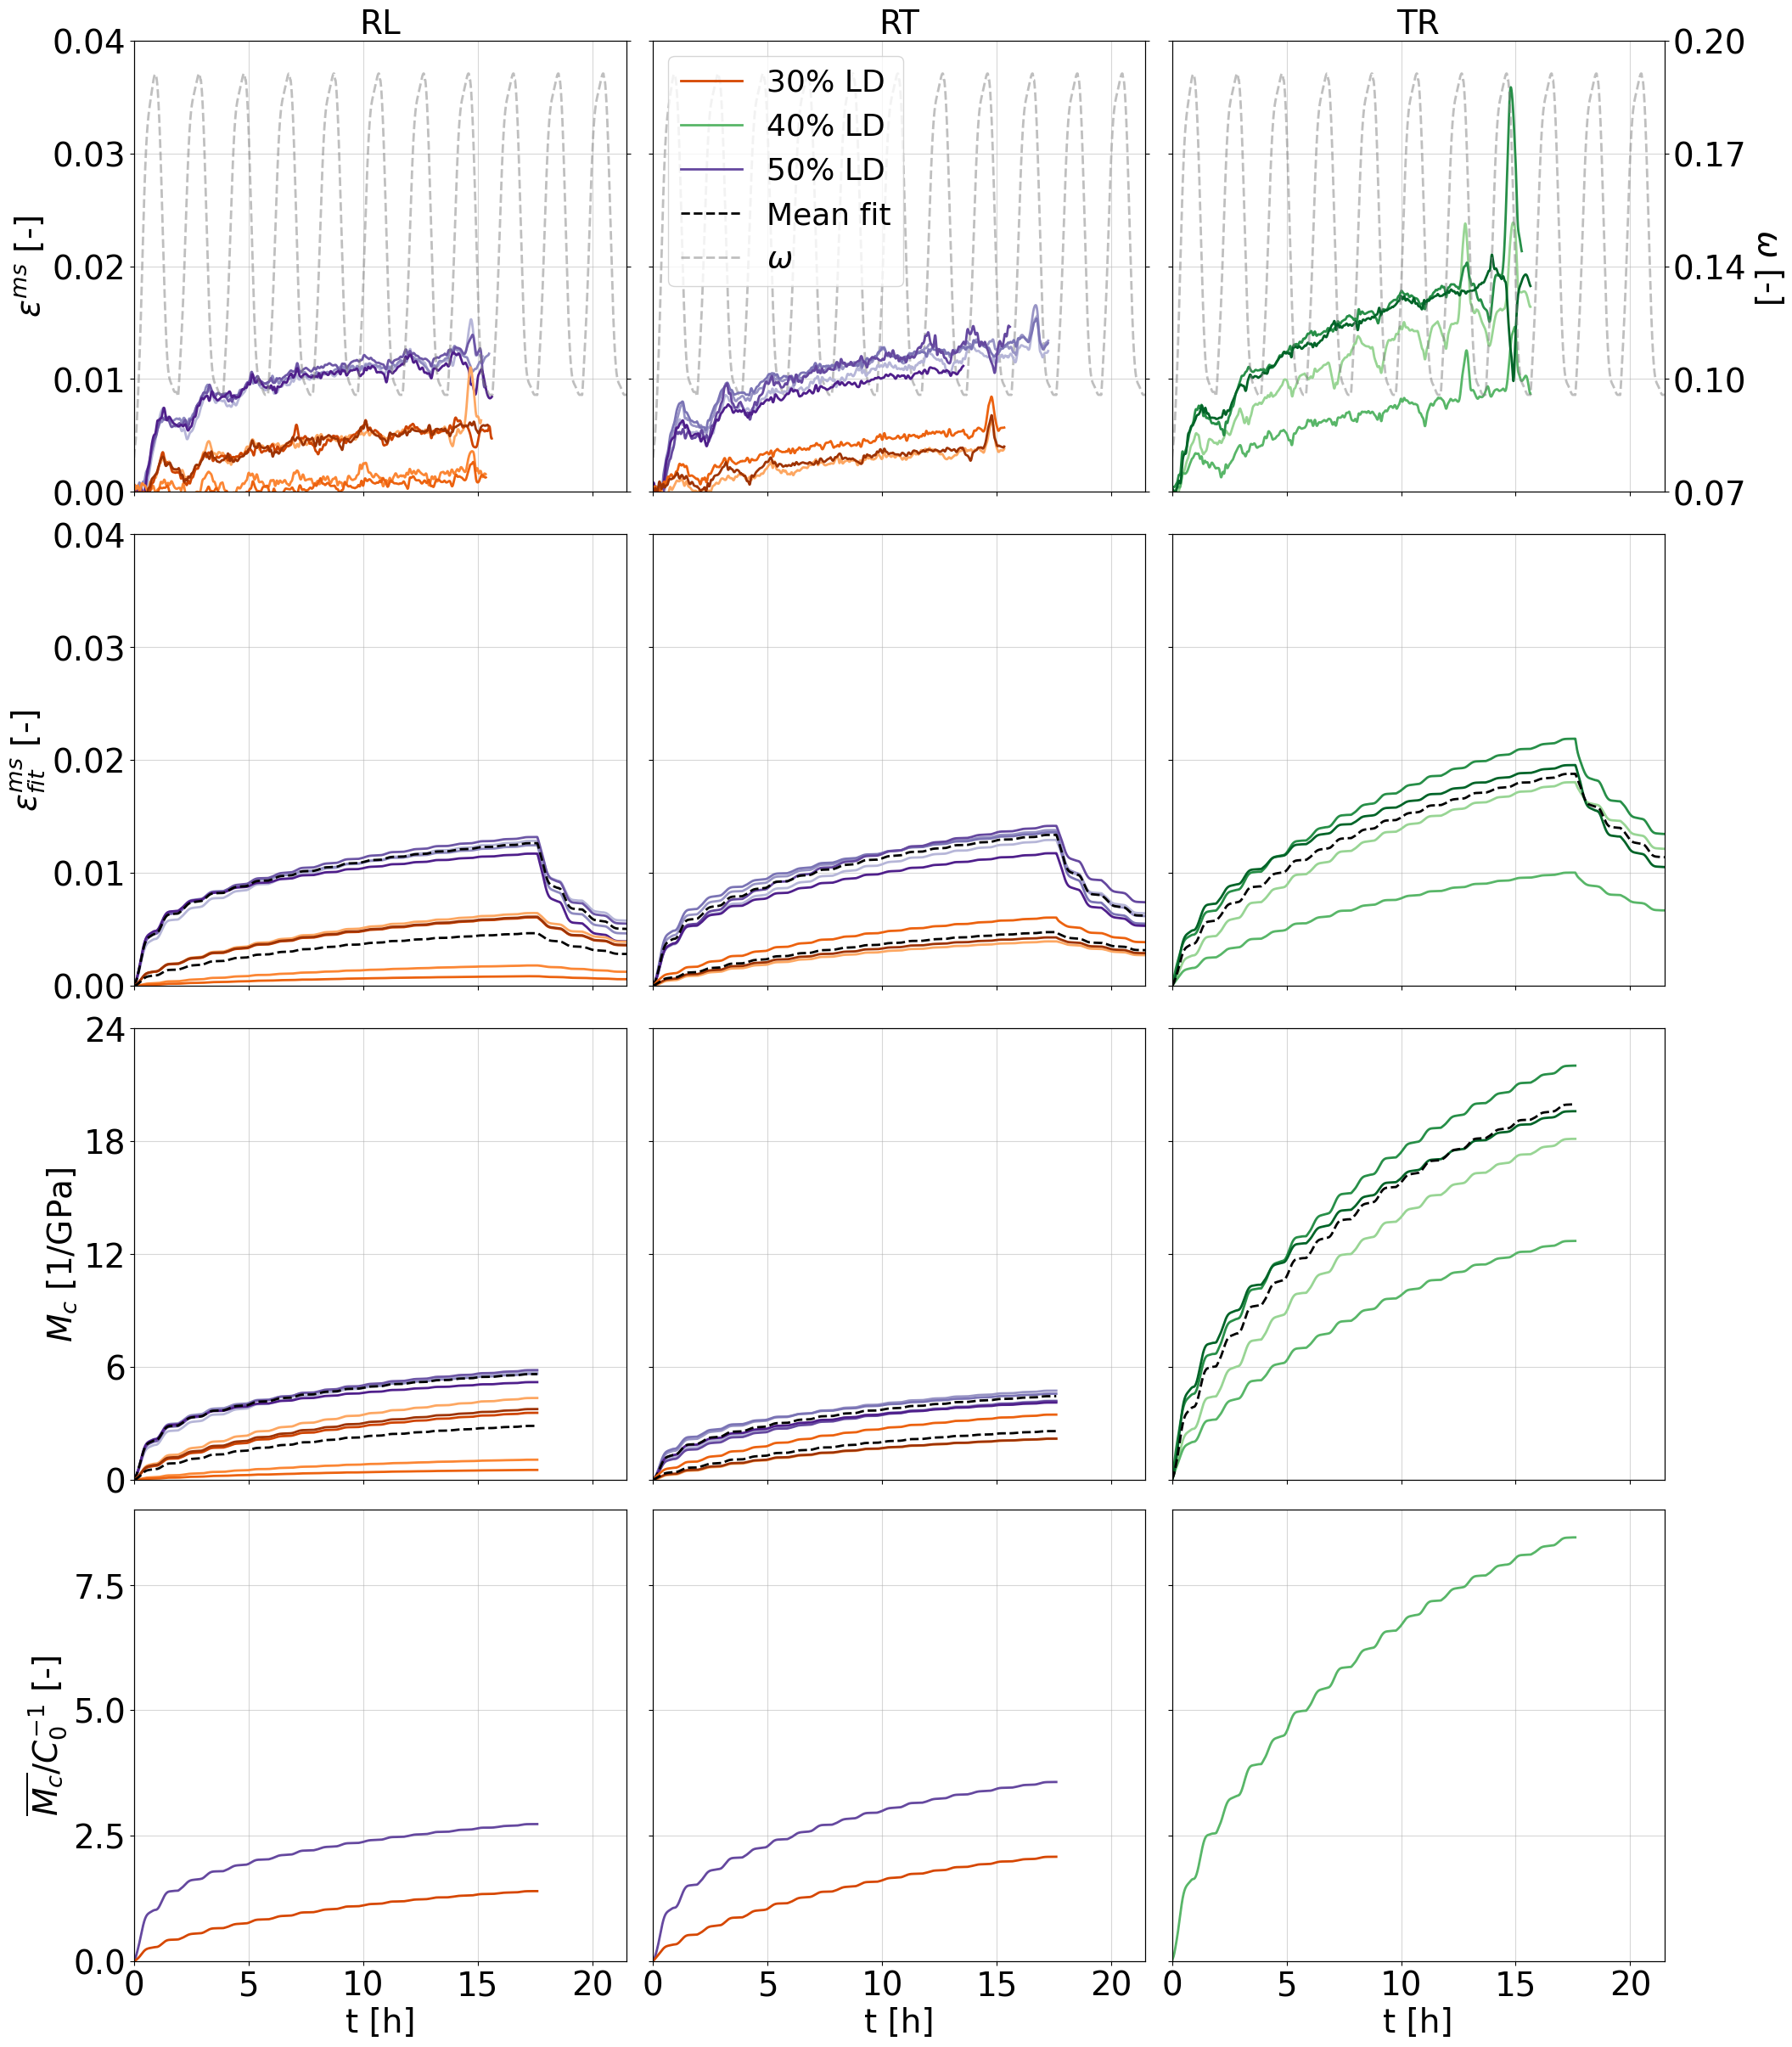

In [4]:
################## PLOT MS RESULTS ##################
# Set layout variables
fontsize = 28
linewidth = 2
ylim_row1 = 0.04 # eps [-]
ylim_row2 = ylim_row1
ylim_row3 = 24 # Mc [1/GPa]
ylim_row4 = 9 # normalized Mc [-]
xlim = 21.5 # time [h]
w_ref = 0.08 # reference moisture content [-] for elastic compliance in normalized compliance

# Generate colormap
cmap_dict = {0.5: cm.Purples, 0.4: cm.Greens, 0.3: cm.Oranges}
dataset_norm = []
for e in dataset:
    e2 = e.copy()
    e2['ld'] = float(np.round(e['ld'], 1)) if e.get('ld') is not None else e.get('ld')
    dataset_norm.append(e2)
_, rep_colors = build_ld_colormaps(dataset_norm, cmap_dict)

# Retrive elastic compliance fit
comp_el = fit_elastic_comp(elastic_path)  # dict: sample_type -> (a,b,c)

# Prepare plot
fig, axes = plt.subplots(4, len(sample_types), figsize=(7 * len(sample_types), 6 * 4), constrained_layout=True)
ax_leg = None
last_ax2 = None

for row in range(4):
    for col, sample_type in enumerate(sample_types):
        ax1 = axes[row, col]
        ax2 = ax1.twinx()
        last_ax2 = ax2
    
        # Subset for this sample_type
        entries = [e for e in dataset_norm if e['sample_type'] == sample_type]
        grouped, colors_by_ld = group_and_colors(entries)

        for ld_val, group in grouped.items():
            eps_fit_list = []
            s_list = []
            for entry, color in zip(group, colors_by_ld[ld_val]):
                # Retrieve datasets
                w_full = entry['w_full'] # [-]
                t_full = entry['t_full'] # [h]
                s_full = entry['s_full'] # [MPa]
                eps_full = entry['eps_full'] # [-]
                comp_opt = entry['meta'].get('comp_opt', None)

                # Customize plots
                ax1, ax2 = customize_plot(ax1, ax2, fontsize)
                ax1.set_xlim(right=xlim)
    
                # Row 1: extracted mechanosorptive strain
                if row == 0:
                    ax1.plot(t_full, eps_full, '-', color=color, linewidth=linewidth)

                # Row 2: fitted mechanosorptive strain
                elif row == 1:
                    # Reference grid
                    t_new, w_new, s_new = build_cycles_with_initial(tdata0, wdata0, tdata, wdata, total_cycles=11, stress_value=s_full[0], stressed_cycles=9)
                    eps_model_ref = mechanosorptive_model(comp_opt, s_new, t_new, w_new)
                    eps_fit_list.append(eps_model_ref)
                    ax1.plot(t_new, eps_model_ref, '-', color=color, linewidth=linewidth)

                # Row 3: fitted mechanosorptive compliance
                elif row == 2:
                    # Reference grid
                    t_new, w_new, s_new = build_cycles_with_initial(tdata0, wdata0, tdata, wdata, total_cycles=9, stress_value=s_full[0], stressed_cycles=9)
                    eps_fit = mechanosorptive_model(comp_opt, s_new, t_new, w_new)
                    eps_fit_list.append(eps_fit)
                    s_list.append(s_new)
                    Mc = np.where(s_new != 0, eps_fit / s_new, np.nan) * 1000.0  # [1/GPa]
                    ax1.plot(t_new, Mc, '-', color=color, linewidth=linewidth)

                # Row 4: normalized mechanosorptive compliance
                else:
                    # Reference grid
                    t_new, w_new, s_new = build_cycles_with_initial(tdata0, wdata0, tdata, wdata, total_cycles=9, stress_value=s_full[0], stressed_cycles=9)
                    eps_fit = mechanosorptive_model(comp_opt, s_new, t_new, w_new)
                    eps_fit_list.append(eps_fit)
                    s_list.append(s_new)

            if row == 1:
                if len(eps_fit_list):
                    # Trimmed-mean
                    exp_eps_ms = trim_mean(eps_fit_list, 0.3, axis=0)
                    def resid_mean(cj):
                        return mechanosorptive_model(cj, s_new, t_new, w_new) - exp_eps_ms
                    res_mean = least_squares(resid_mean, np.array([0.01, 0.01, 0.01], float), bounds=(0, np.inf), xtol=1e-12, ftol=1e-12)
                    comp_mean = res_mean.x
                    eps_ms_mean = mechanosorptive_model(comp_mean, s_new, t_new, w_new)
                    ax1.plot(t_new, eps_ms_mean, '--', color='black', linewidth=linewidth)
            
            elif row == 2:
                if len(eps_fit_list):
                    # Trimmed-mean
                    exp_eps_ms = trim_mean(eps_fit_list, 0.3, axis=0)
                    def resid_mean(cj):
                        return mechanosorptive_model(cj, s_new, t_new, w_new) - exp_eps_ms
                    res_mean = least_squares(resid_mean, np.array([0.01, 0.01, 0.01], float),bounds=(0, np.inf), xtol=1e-12, ftol=1e-12)
                    comp_mean = res_mean.x
                    eps_ms_mean = mechanosorptive_model(comp_mean, s_new, t_new, w_new)
                    s_mean = np.mean(s_list)#, axis=0)
                    Mc_mean = eps_ms_mean / s_mean * 1000.0
                    ax1.plot(t_new, Mc_mean, '--', color='black', linewidth=linewidth)

            elif row == 3:
                if len(eps_fit_list):
                    # Trimmed-mean
                    exp_eps_ms = trim_mean(eps_fit_list, 0.3, axis=0)
                    def resid_mean(cj):
                        return mechanosorptive_model(cj, s_new, t_new, w_new) - exp_eps_ms
                    res_mean = least_squares(resid_mean, np.array([0.01, 0.01, 0.01], float),bounds=(0, np.inf), xtol=1e-12, ftol=1e-12)
                    comp_mean = res_mean.x
                    eps_ms_mean = mechanosorptive_model(comp_mean, s_new, t_new, w_new)
                    s_mean = np.mean(s_list)#, axis=0)
                    Mc_mean = eps_ms_mean / s_mean

                    # Calculate elastic compliance
                    a, b, c = comp_el[sample_type]
                    C_i = a * w_ref**2 + b * w_ref + c
                    # Plot normalized compliance
                    ax1.plot(t_new, Mc_mean/C_i, '-', color=rep_colors[ld_val], linewidth=linewidth)

        # Customize axes
        if row == 0:
            # Plot moisture cycles
            t_new, w_new, s_new = build_cycles_with_initial(tdata0, wdata0, tdata, wdata, total_cycles=11, stress_value=s_full[0], stressed_cycles=9)
            ax2.plot(t_new, w_new, linestyle='--', color='grey', label=r'$\omega$', linewidth=linewidth, alpha=0.5)
            ax1.locator_params(axis='x', nbins=5)
            if sample_type == 'RL': ax_ref = ax1
            ax1.set_xticklabels([])
            ax1.set_xlabel('')
            ax1.set_ylim(top=ylim_row1)
            ax1.locator_params(axis='y', nbins=4)
            ax2.set_ylim(bottom=0.07, top=0.2)
            set_shared_grid(ax1, ax2)
            ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

            if sample_type in ('RT', 'TR'):
                ax1.set_ylabel('')
                ax1.set_yticklabels([])
            else:
                ax1.set_ylabel(r'$\varepsilon^{ms}$ [-]', fontsize=fontsize)
            if sample_type == 'TR': ax2.set_ylabel(r'$\omega$ [-]', fontsize=fontsize, rotation=270, labelpad=32)
            if sample_type in ('RT', 'RL'): ax2.set_yticklabels([])
            if sample_type == 'RT': ax_leg = ax1
            

            # Set title
            ax1.set_title(sample_type, fontsize=fontsize)

        elif row == 1:
            match_tick_values(ax_ref, ax1, axis='y', copy_labels=True, copy_limits=True)
            match_tick_values(ax_ref, ax1, axis='x', copy_labels=True, copy_limits=True)
            ax1.set_ylim(top=ylim_row2)
            ax1.set_xlabel('')
            ax1.set_xticklabels([])
            ax2.set_yticks([])
            if sample_type in ('RT', 'TR'):
                ax1.set_ylabel('')
                ax1.set_yticklabels([])
            else:
                ax1.set_ylabel(r'$\varepsilon^{ms}_{fit}$ [-]', fontsize=fontsize)

        elif row == 2:
            match_tick_values(ax_ref, ax1, axis='x', copy_labels=True, copy_limits=True)
            ax1.set_ylim(top=ylim_row3)
            match_tick_count(ax_ref, ax1, axis='y')
            ax1.set_xlabel('')
            ax1.set_xticklabels([])
            ax2.set_yticks([])
            if sample_type == 'RT' or sample_type == 'TR':
                ax1.set_ylabel('')
                ax1.set_yticklabels([])
            else:
                ax1.set_ylabel(r'$M_c$ [1/GPa]', fontsize=fontsize)

        else:
            match_tick_values(ax_ref, ax1, axis='x', copy_labels=True, copy_limits=True)
            ax1.set_xticklabels(ax1.get_xticks())
            ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
            ax1.set_ylim(top=ylim_row4)
            match_tick_count(ax_ref, ax1, axis='y')
            ax2.set_yticks([])
            if sample_type == 'RT' or sample_type == 'TR':
                ax1.set_ylabel('')
                ax1.set_yticklabels([])
            else:
                ax1.set_ylabel(r'$\overline{M_c}/C_0^{-1}$ [-]', fontsize=fontsize)

# Customize legend
legend_handles = []
for ld, color in rep_colors.items():
    legend_handles.append(Line2D([0], [0], color=color, lw=linewidth, label=f'{int(ld*100)}% LD'))
legend_handles = sorted(legend_handles, key=lambda h: int(h.get_label().replace('% LD', '')))
legend_handles.append(Line2D([0], [0], color='black', lw=linewidth, linestyle='--', label='Mean fit'))
legend_handles.append(Line2D([0], [0], color='grey', lw=linewidth, linestyle='--', label=r'$\omega$', alpha=0.5))

if ax_leg is not None and last_ax2 is not None:
    ax_leg.set_zorder(last_ax2.get_zorder() + 1)
    ax_leg.patch.set_alpha(0)
    leg = ax_leg.legend(handles=legend_handles, fontsize=fontsize-2, loc='upper left')
    leg.set_zorder = (1000)

# Show plot
plt.show()

### Plot mean fitted mechanosorptive strain rate

Run the following section to plot the evolution of mean fitted mechanosorptive strain rate $\Delta\overline{\varepsilon}^{ms}_{fit}/\Delta t$, grouped by **sample type** **{RL, RT, TR}** and **loading degree (LD)**, together with moisture cycles $\omega$.

In [ ]:
################## CALCULATE AND PLOT MS STRAIN RATE ##################
# Prepare plot
ylim_top = 0.012
ylim_bott = -0.006
fig, axes = plt.subplots(1, len(sample_types), figsize=(7 * len(sample_types), 6), constrained_layout=True)

# Loop over each sample type
for ax1, sample_type in zip(axes, sample_types):

    ax2 = ax1.twinx()
    # Subset for this sample_type
    entries = [e for e in dataset_norm if e['sample_type'] == sample_type]
    grouped, colors_by_ld = group_and_colors(entries)

    for ld_val, group in grouped.items():
        eps_fit_list = []
        s_list = []
        for entry, color in zip(group, colors_by_ld[ld_val]):
            # Retrieve datasets
            w_full = entry['w_full'] # [-]
            t_full = entry['t_full'] # [h]
            s_full = entry['s_full'] # [MPa]
            eps_full = entry['eps_full'] # [-]
            comp_opt = entry['meta'].get('comp_opt', None)

            # Reference grid
            t_new, w_new, s_new = build_cycles_with_initial(tdata0, wdata0, tdata, wdata, total_cycles=11, stress_value=s_full[0], stressed_cycles=9)
            eps_model_ref = mechanosorptive_model(comp_opt, s_new, t_new, w_new)
            eps_fit_list.append(eps_model_ref)
            
        if len(eps_fit_list):
            # Trimmed-mean
            exp_eps_ms = trim_mean(eps_fit_list, 0.3, axis=0)
            def resid_mean(cj):
                return mechanosorptive_model(cj, s_new, t_new, w_new) - exp_eps_ms
            res_mean = least_squares(resid_mean, np.array([0.01, 0.01, 0.01], float), bounds=(0, np.inf), xtol=1e-12, ftol=1e-12)
            comp_mean = res_mean.x
            eps_ms_mean = mechanosorptive_model(comp_mean, s_new, t_new, w_new)
        
        # Build strain‐rate array (time)
        dt = np.diff(t_new)
        dw = np.diff(w_new)
        deps = np.diff(eps_ms_mean)
        eps_t_rate = deps / dt
        t_filt = t_new[1:]
        # Filter out spikes
        idx = detect_single_point_spikes(eps_t_rate, k=5)
        eps_t_rate = fix_spikes_linear(eps_t_rate, idx)
        ax1.plot(t_filt, eps_t_rate, '-', color=rep_colors[ld_val], linewidth=linewidth)

    # Plot moisture
    ax2.plot(t_new, w_new, linestyle='--', color='grey', label=r'$\omega$', linewidth = linewidth, alpha=0.5)
    # Customize axes
    ax1, ax2 = customize_plot(ax1, ax2, fontsize)
    match_tick_values(ax_ref, ax1, axis='x', copy_labels=True, copy_limits=True)
    ax1.set_xticklabels(ax1.get_xticks())
    ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax1.set_ylim(bottom=ylim_bott, top=ylim_top)
    match_tick_count(ax_ref, ax1, axis='y')
    ax1.set_xlim(right=xlim)
    ax2.set_ylim(bottom = 0.07, top=0.2)
    set_shared_grid(ax1, ax2)
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    if sample_type == 'TR': ax2.set_ylabel(r'$\omega$ [-]', fontsize=fontsize, rotation=270, labelpad=32)
    if sample_type == 'RT' or sample_type == 'RL': ax2.set_yticklabels([])
    if sample_type == 'RT' or sample_type == 'TR':
        ax1.set_ylabel('')
        ax1.set_yticklabels([])
    else:
        ax1.set_ylabel(r'$\Delta\overline{\varepsilon}^{{ms}}_{{fit}} / \Delta t$', fontsize=fontsize)
    if sample_type == 'RT': ax_leg = ax1
    # Customize title
    ax1.set_title(sample_type, fontsize=fontsize)

# Customize legend
legend_handles = []
for ld, color in rep_colors.items():
    legend_handles.append(Line2D([0], [0], color=color, lw=linewidth, label=f'{int(ld*100)}% LD'))
legend_handles = sorted(legend_handles, key=lambda h: int(h.get_label().replace('% LD', '')))
legend_handles.append(Line2D([0], [0], color='grey', lw=linewidth, linestyle='--', label=r'$\omega$', alpha=0.5))
ax_leg.set_zorder(ax2.get_zorder() + 1)
ax_leg.patch.set_alpha(0)
leg = ax_leg.legend(handles=legend_handles, fontsize=fontsize-2, loc='upper right')
leg.set_zorder=(1000)

# Show plot
plt.show()